# COVID-19 Hackathon

## Challenge

In this challenge, we have a training and a test data set consisting of synthetic patient health records. We will develop computational algorithms to model the risk of severe outcomes (e.g. death) to a positive test of COVID-19 in the data population. We will develop a model that will be used to predict mortality for each synthetic patient in the test data set.

## About the data

* COVID-19 status is defined as the patient’s test result from the SARS-CoV-2 test. A negative SARS-CoV-2 test is identified by an observation with “CODE” 94531-1 and “VALUE” of “Not detected (qualifier value)“. The “VALUE” for a positive result is “Detected (qualifier value)“.
* Alive or deceased status is defined as the “DEATHDATE” for a patient. A patient without a “DEATHDATE” is considered alive.

## Importing the data

16 CSV files were made available with patient and hospital data. These files were imported into a database in SQLite and became separate tables.

## Let's begin...

By importing the libraries we'll use in this notebook

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [45]:
# Create a SQL connection to our SQLite database
con = sqlite3.connect("C:\\Users\\cgoss\\Downloads\\SQLiteDatabaseBrowserPortable\\Data\\HealthHack_TrainData.db")

#Get training data
obser = pd.read_sql_query("SELECT * from observations WHERE CODE='94531-1'" , con)
allergies = pd.read_sql_query("SELECT * from allergies" , con)
conditions = pd.read_sql_query("SELECT * from conditions", con)
devices = pd.read_sql_query("SELECT * from devices", con)
immunizations = pd.read_sql_query("SELECT * from immunizations", con)
patients = pd.read_sql_query("SELECT * from patients", con)

# Be sure to close the connection
con.close()

#### The observations table was imported with a filter to get only rows that were for a SARS-CoV-2 test

So, let's take a look at that data, note the DESCRIPTION and the VALUE (the result of the test - Detected or Not detected)

In [46]:
obser.head(10)

,DATE,PATIENT,ENCOUNTER,CODE,DESCRIPTION,VALUE,UNITS,TYPE
0,2020-03-10,30fb496e-b8d3-4d36-8e50-86acb3d1a223,a703222d-f88a-45ef-be97-b3636357b5bc,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Not detected (qualifier value),None,text
1,2020-03-11,afa2680f-7f73-46d9-b0cd-2cf3db49724b,00bee8c8-40e5-433e-ba85-2125f133e5eb,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Detected (qualifier value),None,text
2,2020-02-23,26e5d262-6cdc-4274-a5cd-d7fd439e35f9,08727d55-6b17-4312-9e90-1174f54b9c22,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Detected (qualifier value),None,text
3,2020-03-03,90031c21-e8a4-416e-b60b-23e871ee62dc,630ee0a3-2bb2-434a-a7cb-b37c7f8a43cb,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Detected (qualifier value),None,text
4,2020-03-10,26e5d262-6cdc-4274-a5cd-d7fd439e35f9,e6ad9f78-fa0e-431a-b9b6-5d127a594261,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Not detected (qualifier value),None,text
5,2020-03-11,26e5d262-6cdc-4274-a5cd-d7fd439e35f9,e6ad9f78-fa0e-431a-b9b6-5d127a594261,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Not detected (qualifier value),None,text
6,2020-03-22,90031c21-e8a4-416e-b60b-23e871ee62dc,d068a77c-abcf-4c5e-a8b9-e74cbdbfe099,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Not detected (qualifier value),None,text
7,2020-03-23,90031c21-e8a4-416e-b60b-23e871ee62dc,d068a77c-abcf-4c5e-a8b9-e74cbdbfe099,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Not detected (qualifier value),None,text
8,2020-03-10,0ac2e031-ab88-41f9-ac5d-d7d588952222,6faa29bc-9e80-4386-840e-b9c5ad5644ef,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Detected (qualifier value),None,text
9,2020-03-09,45138fb4-dc79-4aec-ba78-7a012d3edca7,eed09e0e-a9ba-4623-82c7-9e28d90812bc,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Detected (qualifier value),None,text


In [115]:
# From looking at the data, it appears that one patient could have had the test multiple times
len(obser.PATIENT.unique())

73697

In [116]:
obser.shape

(73697, 3)

In [49]:
# These extra tests appear to be a follow-up test a couple weeks after the first positive result
# These extra tests must be confirming that the patient is COVID-19-free.
# Let's drop those follow-up tests by dropping duplicates
obser.drop_duplicates(subset='PATIENT', inplace=True)

In [50]:
# Now we'll drop all rows that lead to a negative test result, we are focusing on POSITIVE test result leading to death
obser.drop(obser[obser['VALUE'] == "Not detected (qualifier value)"].index, axis=0, inplace=True)
obser.shape

(73697, 8)

In [51]:
obser.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73697 entries, 1 to 105547
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DATE         73697 non-null  object
 1   PATIENT      73697 non-null  object
 2   ENCOUNTER    73697 non-null  object
 3   CODE         73697 non-null  object
 4   DESCRIPTION  73697 non-null  object
 5   VALUE        73697 non-null  object
 6   UNITS        0 non-null      object
 7   TYPE         73697 non-null  object
dtypes: object(8)
memory usage: 5.1+ MB


In [52]:
# We'll continually drop columns we are not interested in, here, we only need 3 columns:
obser = obser[['DATE', 'PATIENT', 'ENCOUNTER']]

In [53]:
obser.head()

,DATE,PATIENT,ENCOUNTER
1,2020-03-11,afa2680f-7f73-46d9-b0cd-2cf3db49724b,00bee8c8-40e5-433e-ba85-2125f133e5eb
2,2020-02-23,26e5d262-6cdc-4274-a5cd-d7fd439e35f9,08727d55-6b17-4312-9e90-1174f54b9c22
3,2020-03-03,90031c21-e8a4-416e-b60b-23e871ee62dc,630ee0a3-2bb2-434a-a7cb-b37c7f8a43cb
8,2020-03-10,0ac2e031-ab88-41f9-ac5d-d7d588952222,6faa29bc-9e80-4386-840e-b9c5ad5644ef
9,2020-03-09,45138fb4-dc79-4aec-ba78-7a012d3edca7,eed09e0e-a9ba-4623-82c7-9e28d90812bc


### We are ready for our first table merge now! 

Let's add basic patient data to the positive COVID19 observations and create a new "master" dataframe.

In [54]:
master = obser.merge(patients, how="left", left_on='PATIENT', right_on='Id')

In [55]:
# Note that PATIENT and Id are the same value, we'll need to drop that
master.head()

,DATE,PATIENT,ENCOUNTER,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,...,BIRTHPLACE,ADDRESS,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE
0,2020-03-11,afa2680f-7f73-46d9-b0cd-2cf3db49724b,00bee8c8-40e5-433e-ba85-2125f133e5eb,afa2680f-7f73-46d9-b0cd-2cf3db49724b,1978-06-16,None,999-21-2569,S99940488,X6135636X,Mrs.,...,Boston Massachusetts US,128 Considine Plaza Apt 21,Wakefield,Massachusetts,Middlesex County,1880.0,42.460402,-71.113293,878157.60,8128.09
1,2020-02-23,26e5d262-6cdc-4274-a5cd-d7fd439e35f9,08727d55-6b17-4312-9e90-1174f54b9c22,26e5d262-6cdc-4274-a5cd-d7fd439e35f9,1989-09-05,None,999-39-4400,S99956192,X43478634X,Mr.,...,Hamilton Massachusetts US,840 Brekke Union,Weston,Massachusetts,Middlesex County,None,42.338808,-71.341510,21147.02,0.00
2,2020-03-03,90031c21-e8a4-416e-b60b-23e871ee62dc,630ee0a3-2bb2-434a-a7cb-b37c7f8a43cb,90031c21-e8a4-416e-b60b-23e871ee62dc,1983-07-24,None,999-86-1503,S99937062,X73557271X,Mrs.,...,Charlton Massachusetts US,475 Cronin Manor Unit 94,Millville,Massachusetts,Worcester County,None,42.010525,-71.622337,746790.89,12704.15
3,2020-03-10,0ac2e031-ab88-41f9-ac5d-d7d588952222,6faa29bc-9e80-4386-840e-b9c5ad5644ef,0ac2e031-ab88-41f9-ac5d-d7d588952222,1996-02-17,None,999-28-9132,S99982506,X18319389X,Mr.,...,Holbrook Massachusetts US,561 Crona Byway Unit 38,Boston,Massachusetts,Suffolk County,2199.0,42.377211,-70.996938,620087.37,8129.28
4,2020-03-09,45138fb4-dc79-4aec-ba78-7a012d3edca7,eed09e0e-a9ba-4623-82c7-9e28d90812bc,45138fb4-dc79-4aec-ba78-7a012d3edca7,1960-06-08,None,999-81-6574,S99977268,X8571358X,Mrs.,...,Stoughton Massachusetts US,807 Maggio Grove,Boston,Massachusetts,Suffolk County,2134.0,42.350963,-71.133840,32286.70,1659.84


In [56]:
# To be sure, let's confirm we have the same number of rows before/after the merge
master.shape

(73697, 28)

### Featuring engineering #1 - ISDEAD - this, unfortunately, is our target

In [57]:
master["ISDEAD"] = master['DEATHDATE'].notnull()
master.loc[(master.ISDEAD == True), 'ISDEAD'] = 1
master.loc[(master.ISDEAD == False), 'ISDEAD'] = 0

In [58]:
master['ISDEAD'].value_counts()

0    68129
1     5568
Name: ISDEAD, dtype: int64

In [59]:
print('Percentage of people in our dataset who tested positive for COVID-19 and ultimately died: {:.1f}%'.format(5568/73697 * 100))

Percentage of people in our dataset who tested positive for COVID-19 and ultimately died: 7.6%


In [60]:
# We'll continually drop columns we are not interested in:
master.drop(['Id', 'SSN', 'DRIVERS', 'PASSPORT', 'MAIDEN', 'BIRTHPLACE', 'ADDRESS', 'STATE', 'PREFIX', 'SUFFIX'], axis=1, inplace=True)

In [61]:
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73697 entries, 0 to 73696
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE                 73697 non-null  object 
 1   PATIENT              73697 non-null  object 
 2   ENCOUNTER            73697 non-null  object 
 3   BIRTHDATE            73697 non-null  object 
 4   DEATHDATE            5568 non-null   object 
 5   FIRST                73697 non-null  object 
 6   LAST                 73697 non-null  object 
 7   MARITAL              67360 non-null  object 
 8   RACE                 73697 non-null  object 
 9   ETHNICITY            73697 non-null  object 
 10  GENDER               73697 non-null  object 
 11  CITY                 73697 non-null  object 
 12  COUNTY               73697 non-null  object 
 13  ZIP                  39687 non-null  object 
 14  LAT                  73697 non-null  float64
 15  LON                  73697 non-null 

### Time to add more features to our master DF - Allergies

Our "allergies" table tracks 7 allergies. We started by taking the most common, mould allergy

In [62]:
mould_allergy = allergies.loc[(allergies['CODE'] == 419474003)]
type(mould_allergy)
mould_allergy.head()
mould_allergy.shape

(3966, 6)

In [63]:
#merge patients that have a mould allergy into master dataframe (DF)
master = master.merge(mould_allergy, how="left", on='PATIENT')

In [64]:
master.CODE.value_counts()

419474003.0    2884
Name: CODE, dtype: int64

In [65]:
# Feature engineering to make a boolean column from the Allergy CODE column
master["CODE"] = master['CODE'].notnull()
master.loc[(master.CODE == True), 'CODE'] = 1
master.loc[(master.CODE == False), 'CODE'] = 0

In [66]:
# We decided to rename column names so that they better indicate what the boolean value meant
# For example, instead of a column named "ETHNICITY", it's clearer with a 1 or a 0 to answer the question "ISHISPANIC"

master.rename(columns={'CODE':'HAS_MOULD_ALLERGY', 'DATE':'DATE_TESTED_POSITIVE', 'ETHNICITY':'ISHISPANIC', 'GENDER':'ISFEMALE'}, inplace = True)

In [67]:
# We'll continually drop columns we are not interested in
master.drop(['ENCOUNTER_x', 'START', 'STOP', 'ENCOUNTER_y', 'DESCRIPTION'], axis=1, inplace=True)

### We are now ready to add more features to the master DF: DIABETES

In [68]:
# merge patients that have diabetes into master df
diabetes_patients = conditions.loc[(conditions['CODE'] == 44054006)]
#diabetes_patients.rename(columns={'CODE':'HAS_DIABETES'}, inplace=True)
print(diabetes_patients.shape)
#diabetes_patients.head()

(23686, 6)


In [69]:
master.columns

Index(['DATE_TESTED_POSITIVE', 'PATIENT', 'BIRTHDATE', 'DEATHDATE', 'FIRST',
       'LAST', 'MARITAL', 'RACE', 'ISHISPANIC', 'ISFEMALE', 'CITY', 'COUNTY',
       'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE',
       'ISDEAD', 'HAS_MOULD_ALLERGY'],
      dtype='object')

In [70]:
diabetes_patients.columns

Index(['START', 'STOP', 'PATIENT', 'ENCOUNTER', 'CODE', 'DESCRIPTION'], dtype='object')

In [71]:
master = master.merge(diabetes_patients, how='left', on='PATIENT')
master.columns

Index(['DATE_TESTED_POSITIVE', 'PATIENT', 'BIRTHDATE', 'DEATHDATE', 'FIRST',
       'LAST', 'MARITAL', 'RACE', 'ISHISPANIC', 'ISFEMALE', 'CITY', 'COUNTY',
       'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE',
       'ISDEAD', 'HAS_MOULD_ALLERGY', 'START', 'STOP', 'ENCOUNTER', 'CODE',
       'DESCRIPTION'],
      dtype='object')

In [72]:
# This is our periodic column dropping to keep things tidy, also rename the CODE column
master.drop(['START', 'STOP', 'ENCOUNTER', 'DESCRIPTION'], axis=1, inplace=True)
master.rename(columns={'CODE':'HAS_DIABETES'}, inplace=True)

In [73]:
print(master.columns)
master.shape

Index(['DATE_TESTED_POSITIVE', 'PATIENT', 'BIRTHDATE', 'DEATHDATE', 'FIRST',
       'LAST', 'MARITAL', 'RACE', 'ISHISPANIC', 'ISFEMALE', 'CITY', 'COUNTY',
       'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE',
       'ISDEAD', 'HAS_MOULD_ALLERGY', 'HAS_DIABETES'],
      dtype='object')


(73697, 20)

In [74]:
master["HAS_DIABETES"] = master['HAS_DIABETES'].notnull()
master.loc[(master.HAS_DIABETES == True), 'HAS_DIABETES'] = 1
master.loc[(master.HAS_DIABETES == False), 'HAS_DIABETES'] = 0

In [75]:
master.shape

(73697, 20)

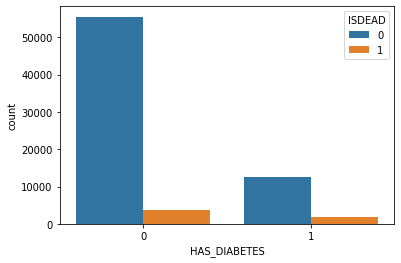

In [91]:
sns.countplot(x = 'HAS_DIABETES', hue = 'ISDEAD', data = master)

### Time for more features: HEART and KIDNEY issues

Our research showed us that HEART and KIDNEY issues were indicators of "severe outcomes" to COVID-19
See: https://www.cdc.gov/coronavirus/2019-ncov/need-extra-precautions/people-with-medical-conditions.html

We started by pulling these devices into individual columns for each patient, then merged them into a final two - one for heart, and one for lung.

The way we are getting this data is through the devices table:
* If a patient has a pacemaker, stent, or debibrillator, we are concluding they have heart issues
* If a patient is on dialysis, we are concluding they have kidney issues
* If a patient has either videolaryngoscope or a ventilator, we are concluding these are complications related to COVID-19, and not a pre-existing condition that would be a relevant factor in determining death

In [76]:
devices.DESCRIPTION.value_counts()

Hemodialysis machine  device (physical object)         14088
Implantable defibrillator  device (physical object)     5760
Mechanical ventilator (physical object)                 4210
Videolaryngoscope (physical object)                     4210
Coronary artery stent (physical object)                 3698
Implantable cardiac pacemaker (physical object)         1530
Name: DESCRIPTION, dtype: int64

In [77]:
# let's add if a patient has a device - these seem to indicate weak heart or kidney
device_patients = devices.loc[(master['PATIENT'].isin(devices['PATIENT']))]
#diabetes_patients.rename(columns={'CODE':'HAS_DIABETES'}, inplace=True)
print(device_patients.shape)
device_patients.drop(['START', 'STOP', 'ENCOUNTER', 'DESCRIPTION', 'UDI'], axis=1, inplace=True)
device_patients.head()


(3590, 7)


C:\Users\cgoss\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PATIENT,CODE
9,534e1ef3-b3c7-42da-a022-fea54d6c828f,449071006
14,534e1ef3-b3c7-42da-a022-fea54d6c828f,36965003
23,5158d043-8c93-4987-8fcb-5f94e7e32fa1,36965003
36,358b784d-cccb-421e-84af-033aecec250b,706004007
38,e95e1cce-8950-432b-b56b-907b9e2696d7,705643001


In [78]:
# let's split out which device a patient has
dialysis_patients = device_patients.loc[(device_patients['CODE'] == 36965003)]
dialysis_patients.drop_duplicates(subset ="PATIENT", keep = 'first', inplace = True) 
debfib_patients = device_patients.loc[(device_patients['CODE'] == 72506001)]
vent_patients = device_patients.loc[(device_patients['CODE'] == 449071006)]
video_patients = device_patients.loc[(device_patients['CODE'] == 448907002)]
stent_patients = device_patients.loc[(device_patients['CODE'] == 705643001)]
pacemaker_patients = device_patients.loc[(device_patients['CODE'] == 706004007)]

C:\Users\cgoss\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [79]:
#merge patients that have each diff device into master df in its own column
master = master.merge(dialysis_patients, how="left", on='PATIENT')
master.rename(columns={'CODE':'HAS_DIALYSIS'}, inplace=True)
master = master.merge(debfib_patients, how="left", on='PATIENT')
master.rename(columns={'CODE':'HAS_DEFIB'}, inplace=True)
master = master.merge(vent_patients, how="left", on='PATIENT')
master.rename(columns={'CODE':'HAS_VENT'}, inplace=True)
master = master.merge(video_patients, how="left", on='PATIENT')
master.rename(columns={'CODE':'HAS_VIDEO'}, inplace=True)
master = master.merge(stent_patients, how="left", on='PATIENT')
master.rename(columns={'CODE':'HAS_STENT'}, inplace=True)
master = master.merge(pacemaker_patients, how="left", on='PATIENT')
master.rename(columns={'CODE':'HAS_PACEMAKER'}, inplace=True)

In [80]:
master["HAS_KIDNEY_ISSUE"] = master['HAS_DIALYSIS'].notnull()
master.loc[(master.HAS_KIDNEY_ISSUE == True), 'HAS_KIDNEY_ISSUE'] = 1
master.loc[(master.HAS_KIDNEY_ISSUE == False), 'HAS_KIDNEY_ISSUE'] = 0
master.drop(['HAS_DIALYSIS'], axis=1, inplace=True)

In [81]:
# We wanted to simplify by merging the 3 HEART-related devices into one column
master["HAS_HEART_ISSUE"] = master[['HAS_DEFIB', 'HAS_PACEMAKER', 'HAS_STENT']].any(axis=1)
master.loc[(master.HAS_HEART_ISSUE == True), 'HAS_HEART_ISSUE'] = 1
master.loc[(master.HAS_HEART_ISSUE == False), 'HAS_HEART_ISSUE'] = 0
master.drop(['HAS_DEFIB', 'HAS_PACEMAKER', 'HAS_STENT'], axis=1, inplace=True)

In [85]:
print('Percent of our COVID-19 positive patients that have a heart issue: {:.3f}'.format(master.HAS_HEART_ISSUE.mean() * 100))

Percent of our COVID-19 positive patients that have a heart issue: 0.594


In [86]:
print('Percent of our COVID-19 positive patients that have a kidney issue: {:.1f}'.format(master.HAS_KIDNEY_ISSUE.mean() * 100))

Percent of our COVID-19 positive patients that have a kidney issue: 1.4


In [87]:
master.shape

(73697, 24)

In [88]:
master.head()

,DATE_TESTED_POSITIVE,PATIENT,BIRTHDATE,DEATHDATE,FIRST,LAST,MARITAL,RACE,ISHISPANIC,ISFEMALE,...,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,ISDEAD,HAS_MOULD_ALLERGY,HAS_DIABETES,HAS_VENT,HAS_VIDEO,HAS_KIDNEY_ISSUE,HAS_HEART_ISSUE
0,2020-03-11,afa2680f-7f73-46d9-b0cd-2cf3db49724b,1978-06-16,None,Janeth814,Beatty507,M,white,nonhispanic,F,...,-71.113293,878157.60,8128.09,0,0,0,NaN,NaN,0,0
1,2020-02-23,26e5d262-6cdc-4274-a5cd-d7fd439e35f9,1989-09-05,None,Adrian111,Blanda868,S,white,nonhispanic,M,...,-71.341510,21147.02,0.00,0,0,0,NaN,NaN,0,0
2,2020-03-03,90031c21-e8a4-416e-b60b-23e871ee62dc,1983-07-24,None,Peggie783,Turcotte120,M,white,nonhispanic,F,...,-71.622337,746790.89,12704.15,0,0,1,NaN,NaN,0,0
3,2020-03-10,0ac2e031-ab88-41f9-ac5d-d7d588952222,1996-02-17,None,Cecil300,Barton704,None,black,nonhispanic,M,...,-70.996938,620087.37,8129.28,0,0,0,NaN,NaN,0,0
4,2020-03-09,45138fb4-dc79-4aec-ba78-7a012d3edca7,1960-06-08,None,Shiloh191,Turner526,M,white,hispanic,F,...,-71.133840,32286.70,1659.84,0,0,0,NaN,NaN,0,0


In [89]:
master.head(10)

,DATE_TESTED_POSITIVE,PATIENT,BIRTHDATE,DEATHDATE,FIRST,LAST,MARITAL,RACE,ISHISPANIC,ISFEMALE,...,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,ISDEAD,HAS_MOULD_ALLERGY,HAS_DIABETES,HAS_VENT,HAS_VIDEO,HAS_KIDNEY_ISSUE,HAS_HEART_ISSUE
0,2020-03-11,afa2680f-7f73-46d9-b0cd-2cf3db49724b,1978-06-16,None,Janeth814,Beatty507,M,white,nonhispanic,F,...,-71.113293,878157.60,8128.09,0,0,0,NaN,NaN,0,0
1,2020-02-23,26e5d262-6cdc-4274-a5cd-d7fd439e35f9,1989-09-05,None,Adrian111,Blanda868,S,white,nonhispanic,M,...,-71.341510,21147.02,0.00,0,0,0,NaN,NaN,0,0
2,2020-03-03,90031c21-e8a4-416e-b60b-23e871ee62dc,1983-07-24,None,Peggie783,Turcotte120,M,white,nonhispanic,F,...,-71.622337,746790.89,12704.15,0,0,1,NaN,NaN,0,0
3,2020-03-10,0ac2e031-ab88-41f9-ac5d-d7d588952222,1996-02-17,None,Cecil300,Barton704,None,black,nonhispanic,M,...,-70.996938,620087.37,8129.28,0,0,0,NaN,NaN,0,0
4,2020-03-09,45138fb4-dc79-4aec-ba78-7a012d3edca7,1960-06-08,None,Shiloh191,Turner526,M,white,hispanic,F,...,-71.133840,32286.70,1659.84,0,0,0,NaN,NaN,0,0
5,2020-03-06,fba0823a-d6fc-402f-a6c3-9394f54b1870,1981-04-04,None,Man114,Halvorson124,S,white,nonhispanic,M,...,-72.728120,989352.06,3135.56,0,0,0,NaN,NaN,0,0
6,2020-02-11,93ef4d47-2a1e-4af1-b792-96a6077b75e0,1984-08-14,None,Lionel365,D'Amore443,M,white,nonhispanic,M,...,-70.905575,823563.89,3958.76,0,0,0,NaN,NaN,0,0
7,2020-03-05,ff524e84-ef48-4c59-8e16-ff28514271a1,1998-06-17,None,Dessie725,Thiel172,None,white,nonhispanic,F,...,-71.027811,512151.27,4462.12,0,0,0,NaN,NaN,0,0
8,2020-03-12,5c6dd9dd-effb-4ba6-a059-a60579b86ee1,1976-01-27,None,Eldridge510,Wuckert783,S,asian,nonhispanic,M,...,-71.206804,1077512.24,5529.52,0,0,0,NaN,NaN,0,0
9,2020-03-04,c58ae02e-235e-4db2-a9c3-6926e9c0c5fa,1954-03-19,2020-03-15,Tuan998,Schuster709,M,white,nonhispanic,M,...,-71.075393,1423163.19,8303.87,1,0,1,NaN,NaN,0,0


### Now we will add another feature: RACE

In [90]:
master.RACE.value_counts()

white     61959
black      6306
asian      4946
native      400
other        86
Name: RACE, dtype: int64

In [92]:
master.loc[(master.RACE == 'white'), 'RACE'] = 0
master.loc[(master.RACE == 'black'), 'RACE'] = 1
master.loc[(master.RACE == 'asian'), 'RACE'] = 2
master.loc[(master.RACE == 'native'), 'RACE'] = 3
master.loc[(master.RACE == 'other'), 'RACE'] = 4

### And another feature: GENDER

In [98]:
master.loc[(master.ISFEMALE == 'M'), 'ISFEMALE'] = 0
master.loc[(master.ISFEMALE == 'F'), 'ISFEMALE'] = 1

### And another feature: ETHNICITY - only 2 values hispanic/nonhispanic

In [93]:
master.loc[(master.ISHISPANIC == 'nonhispanic'), 'ISHISPANIC'] = 0
master.loc[(master.ISHISPANIC == 'hispanic'), 'ISHISPANIC'] = 1
master.ISHISPANIC.value_counts()

0    65420
1     8277
Name: ISHISPANIC, dtype: int64

### And another feature: AGE

In [94]:
master['BIRTHDATE'] = pd.to_datetime(master['BIRTHDATE'])
master['DEATHDATE'] = pd.to_datetime(master['DEATHDATE'])
master['DATE_TESTED_POSITIVE'] = pd.to_datetime(master['DATE_TESTED_POSITIVE'])

In [95]:
master['AGE_WHEN_TESTED'] = (master['DATE_TESTED_POSITIVE'] - master['BIRTHDATE']).dt.days / 365

In [96]:
master['AGE_WHEN_TESTED'] = master['AGE_WHEN_TESTED'].astype(int)

### FINAL STEP before we start running models: convert all columns to numeric values

In [99]:
master['ISFEMALE'] = pd.to_numeric(master['ISFEMALE'])
master['ISHISPANIC'] = pd.to_numeric(master['ISHISPANIC'])
master['HAS_MOULD_ALLERGY'] = pd.to_numeric(master['HAS_MOULD_ALLERGY'])
master['RACE'] = pd.to_numeric(master['RACE'])
master['ISDEAD'] = pd.to_numeric(master['ISDEAD'])
master['HAS_DIABETES'] = pd.to_numeric(master['HAS_DIABETES'])
master['HAS_HEART_ISSUE'] = pd.to_numeric(master['HAS_HEART_ISSUE'])
master['HAS_KIDNEY_ISSUE'] = pd.to_numeric(master['HAS_KIDNEY_ISSUE'])

master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73697 entries, 0 to 73696
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATE_TESTED_POSITIVE  73697 non-null  datetime64[ns]
 1   PATIENT               73697 non-null  object        
 2   BIRTHDATE             73697 non-null  datetime64[ns]
 3   DEATHDATE             5568 non-null   datetime64[ns]
 4   FIRST                 73697 non-null  object        
 5   LAST                  73697 non-null  object        
 6   MARITAL               67360 non-null  object        
 7   RACE                  73697 non-null  int64         
 8   ISHISPANIC            73697 non-null  int64         
 9   ISFEMALE              73697 non-null  int64         
 10  CITY                  73697 non-null  object        
 11  COUNTY                73697 non-null  object        
 12  ZIP                   39687 non-null  object        
 13  LAT             

In [100]:
master.head()

,DATE_TESTED_POSITIVE,PATIENT,BIRTHDATE,DEATHDATE,FIRST,LAST,MARITAL,RACE,ISHISPANIC,ISFEMALE,...,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,ISDEAD,HAS_MOULD_ALLERGY,HAS_DIABETES,HAS_VENT,HAS_VIDEO,HAS_KIDNEY_ISSUE,HAS_HEART_ISSUE,AGE_WHEN_TESTED
0,2020-03-11,afa2680f-7f73-46d9-b0cd-2cf3db49724b,1978-06-16,NaT,Janeth814,Beatty507,M,0,0,1,...,878157.60,8128.09,0,0,0,NaN,NaN,0,0,41
1,2020-02-23,26e5d262-6cdc-4274-a5cd-d7fd439e35f9,1989-09-05,NaT,Adrian111,Blanda868,S,0,0,0,...,21147.02,0.00,0,0,0,NaN,NaN,0,0,30
2,2020-03-03,90031c21-e8a4-416e-b60b-23e871ee62dc,1983-07-24,NaT,Peggie783,Turcotte120,M,0,0,1,...,746790.89,12704.15,0,0,1,NaN,NaN,0,0,36
3,2020-03-10,0ac2e031-ab88-41f9-ac5d-d7d588952222,1996-02-17,NaT,Cecil300,Barton704,None,1,0,0,...,620087.37,8129.28,0,0,0,NaN,NaN,0,0,24
4,2020-03-09,45138fb4-dc79-4aec-ba78-7a012d3edca7,1960-06-08,NaT,Shiloh191,Turner526,M,0,1,1,...,32286.70,1659.84,0,0,0,NaN,NaN,0,0,59


# At this point, we consider our master data set complete!

We have imported all the data we felt relevant, feature engineered, cleaned the data and are now ready to model

#### Let's create our X and y dataframes

In [102]:
X = master[['HAS_MOULD_ALLERGY', 'ISHISPANIC', 'ISFEMALE', 'RACE', 'AGE_WHEN_TESTED', 'HAS_DIABETES', 'HAS_HEART_ISSUE', 'HAS_KIDNEY_ISSUE']]
y = master['ISDEAD']

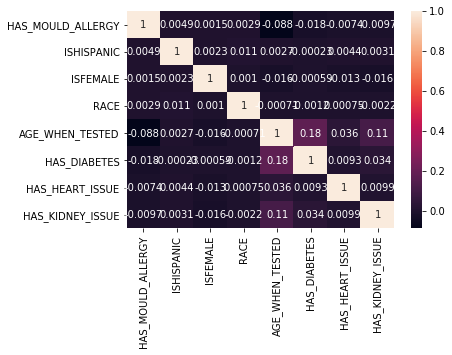

In [103]:
# Check attributes are not highly correlated
sns.heatmap(X.corr(), annot=True)

In [104]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2)

In [105]:
X_train.head()

,HAS_MOULD_ALLERGY,ISHISPANIC,ISFEMALE,RACE,AGE_WHEN_TESTED,HAS_DIABETES,HAS_HEART_ISSUE,HAS_KIDNEY_ISSUE
51458,0,0,0,0,77,0,0,0
51284,0,0,1,0,60,1,0,0
2180,0,0,0,0,49,0,0,0
51142,0,1,1,0,40,0,0,0
22322,0,0,1,0,68,1,0,0


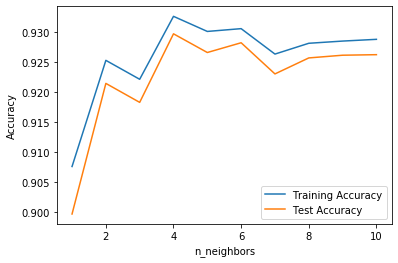

In [107]:
training_accuracy = []
test_accuracy = []
neighbors_settings = range(1,11)
for n in neighbors_settings:
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X_train, y_train)
    training_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))

plt.plot(neighbors_settings, training_accuracy, label="Training Accuracy")
plt.plot(neighbors_settings, test_accuracy, label="Test Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('n_neighbors')
plt.legend()
plt.show()

In [108]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [109]:
y_predictions = knn.predict(X_test)
print("Test set predictions:\n {}".format(y_predictions))

Test set predictions:
 [0 0 0 ... 0 0 0]


In [110]:
print("Test set score: {:.2f}".format(np.mean(y_predictions == y_test)))

Test set score: 0.93


In [111]:
print("Test set score: {:.2f}".format(knn.score(X_test, y_test)))

Test set score: 0.93


In [112]:
print("Actual number of patients who died: {}".format(y_test.to_numpy().sum()))
print("Predicted number of patients who died: {}".format(y_predictions.sum()))

Actual number of patients who died: 1695
Predicted number of patients who died: 336


In [113]:
# Print the resulting confusion matrix
print(confusion_matrix(y_test, y_predictions))

[[20318    97]
 [ 1456   239]]


In [114]:
accuracy = (20318+239)/(1456+97)
print(str(round(accuracy, 2)))

13.24


In [68]:
# Fit a logistic regression model to our train data
logisticRegression.fit(X_train, y_train)
print('Logistic regression accuracy score: {}'.format(logisticRegression.score(X_test, y_test)))

Logistic regression accuracy score: 0.9378561736770692


In [69]:
from matplotlib import pyplot

In [70]:
X.columns

Index(['HAS_MOULD_ALLERGY', 'ISHISPANIC', 'ISFEMALE', 'RACE',
       'AGE_WHEN_TESTED', 'HAS_DIABETES', 'HAS_HEART_ISSUE',
       'HAS_KIDNEY_ISSUE'],
      dtype='object')

In [71]:
importance = logisticRegression.coef_
importance

array([[ 0.20551959,  0.12801364, -0.42066048, -0.01274549,  0.07406647,
         0.40899261, -0.098596  ,  6.73689177]])

In [72]:
# Let's try Random Forest
my_forest = RandomForestClassifier(random_state=1)
my_forest.fit(X_train, y_train)
print('RandomForestClassifier accuracy score: {}'.format(my_forest.score(X_test, y_test)))

RandomForestClassifier accuracy score: 0.936951605608322


In [73]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=None, shuffle=False)
kf

KFold(n_splits=10, random_state=None, shuffle=False)

In [74]:
# see how there are 3 folds (012), (345), (678) and they are split into train (left column) and test) right column
for train_index, test_index in kf.split([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]):
    print(train_index, test_index)

[ 2  3  4  5  6  7  8  9 10 11] [0 1]
[ 0  1  4  5  6  7  8  9 10 11] [2 3]
[ 0  1  2  3  5  6  7  8  9 10 11] [4]
[ 0  1  2  3  4  6  7  8  9 10 11] [5]
[ 0  1  2  3  4  5  7  8  9 10 11] [6]
[ 0  1  2  3  4  5  6  8  9 10 11] [7]
[ 0  1  2  3  4  5  6  7  9 10 11] [8]
[ 0  1  2  3  4  5  6  7  8 10 11] [9]
[ 0  1  2  3  4  5  6  7  8  9 11] [10]
[ 0  1  2  3  4  5  6  7  8  9 10] [11]


In [75]:
def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [76]:
# for example
get_score(LogisticRegression(max_iter = 10000), X_train, X_test, y_train, y_test)

0.9378561736770692

In [77]:
from sklearn.model_selection import cross_val_score

In [78]:
cross_val_score(LogisticRegression(max_iter = 10000), X, y)
# This method does the same thing as the for loop above to get the scores

array([0.93778833, 0.93880597, 0.9380555 , 0.93873397, 0.93975168])

In [79]:
cross_val_score(RandomForestClassifier(n_estimators=40), X, y)

array([0.93643148, 0.93738128, 0.93649501, 0.93778411, 0.93825904])

In [80]:
cross_val_score(SVC(), X, y)

array([0.92442334, 0.92442334, 0.92448606, 0.92448606, 0.92441821])

In [81]:
# Let's run our data through an SVR model
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.svm import SVR

In [82]:
X_svr = preprocessing.scale(X)
y_svr = np.array(y)

In [83]:
type(X_svr)

numpy.ndarray

In [84]:
type(y_svr)

numpy.ndarray

In [85]:
scores = []
best_svr = SVR(kernel='linear')
cv = KFold(n_splits=3, shuffle=False)
for train_index, test_index in cv.split(X_svr):
    print("Train index: ", train_index, "\n")
    print("Test index: ", test_index,)
    
    X_train, X_test, y_train, y_test = X_svr[train_index], X_svr[test_index], y_svr[train_index], y_svr[test_index]
    best_svr.fit(X_train, y_train)
    scores.append(best_svr.score(X_test, y_test))
    
print(np.mean(scores))

Train index:  [24566 24567 24568 ... 73694 73695 73696] 

Test index:  [    0     1     2 ... 24563 24564 24565]
Train index:  [    0     1     2 ... 73694 73695 73696] 

Test index:  [24566 24567 24568 ... 49129 49130 49131]
Train index:  [    0     1     2 ... 49129 49130 49131] 

Test index:  [49132 49133 49134 ... 73694 73695 73696]
0.15407851735966785


In [86]:
scores

[0.15126941281828532, 0.1456263032521754, 0.16533983600854285]

In [88]:
# try SVR regression with X and y as is, not scaled or preprocessed
cross_val_score(SVR(kernel='linear'), X, y)

array([0.1482199 , 0.15217874, 0.14894451, 0.15290467, 0.1670069 ])

In [89]:
# try SVR regression with X_svr and y_svr where I preprocessed them a few cells above
# in this case, the preprocessing does not appear to make much difference in the scores
cross_val_score(SVR(kernel='linear'), X_svr, y_svr)

array([0.14856289, 0.1519725 , 0.1484676 , 0.15342904, 0.16719975])

In [ ]:
# ^^^ I must be doing something wrong, these scores are terrible!! :-)